# Tiling images with overlap
When processing images in tiles, we can observe artifacts on borders of the tiles in the resulting image. One strategy to prevent these artifacts is to process tiles with some overlap. [dask](https://docs.dask.org/en/stable/) also supports this. Again, for demonstration purposes, we use `imshow` to show the resulting images. If these were big data, the `imshow` function would not work.

In [1]:
import dask
import dask.array as da
from skimage.filters import gaussian
from skimage.data import cells3d
from stackview import imshow
from skimage.io import imread

Similar to the example in the last lesson, we define a procedure that applies a Gaussian blur to an image and prints out the size of the image, just so that we know:

In [2]:
def procedure(image):
    print("processing", image.shape)
    return gaussian(image, sigma=5)

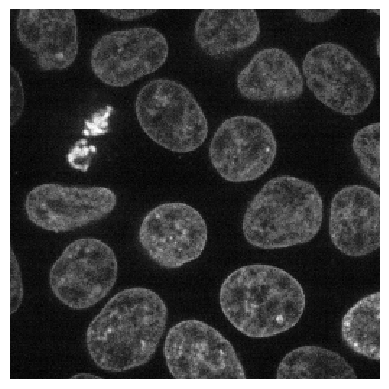

In [3]:
image = imread("data/nuclei2d.tif")
imshow(image)

After loading the image, we tile it as usual.

In [4]:
tiles = da.from_array(image, chunks=(128, 128))
tiles

dask.array<array, shape=(256, 256), dtype=uint16, chunksize=(128, 128), chunktype=numpy.ndarray>

Next, we tell dask what to do with our tiles: We want to map the function `procedure` to the tiles with a [defined overlap](https://docs.dask.org/en/stable/generated/dask.array.map_overlap.html#dask.array.map_overlap).

In [5]:
overlap_width = 1
tile_map = da.map_overlap(procedure, tiles, depth=overlap_width)

processing (0, 0)
processing (1, 1)


The function was executed twice with very small images (0x0 and 1x1 pixels) to check if it works. Next, we actually compute the result.

In [6]:
result = tile_map.compute() # Warning: This loads all image data into memory

processing (129, 129)
processing (129, 129)
processing (129, 129)
processing (129, 129)
processing (128, 128)
processing (128, 128)
processing (128, 128)
processing (128, 128)
processing (132, 132)
processing (132, 132)
processing (140, 140)
processing (140, 140)
processing (140, 140)
processing (144, 144)
processing (144, 144)


From the printed image size, we can see that the processed image size is 2 pixels larger than the tile size. That's the overlap of 1 pixel in all directions. 

## Minimizing border effects
Next, we will compare the result when processing the whole image with the image processed in tiles with different overlaps. This gives us the chance to figure out the minimum necessary overlap width for eliminating border effects. First, we compute the result for the full image.

In [7]:
untiled_result = procedure(image)

processing (256, 256)


Then, we run a for-loop with different `border_width`s.

Overlap width 0
processing (0, 0)
processing (1, 1)


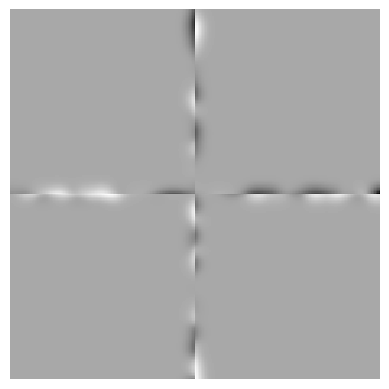

sum difference 1.528818863147824
-----------------------------------
Overlap width 2
processing (0, 0)
processing (1, 1)
processing (132, 132)
processing (132, 132)


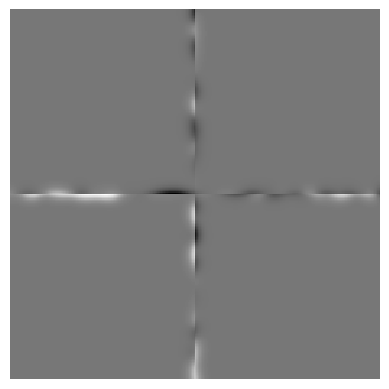

sum difference 5.971294396376637
-----------------------------------
Overlap width 4
processing (0, 0)
processing (1, 1)
processing (136, 136)
processing (136, 136)
processing (136, 136)
processing (136, 136)


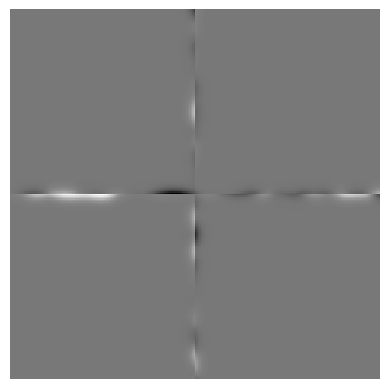

sum difference 3.823608171106622
-----------------------------------
Overlap width 6
processing (0, 0)
processing (1, 1)
processing (140, 140)


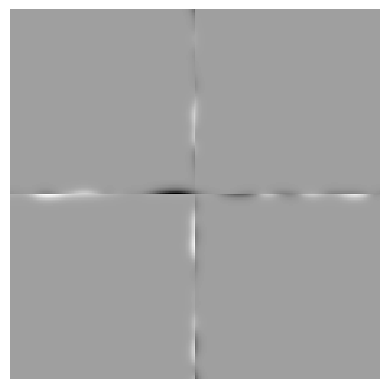

sum difference 0.9650985532492449
-----------------------------------
Overlap width 8
processing (0, 0)
processing (1, 1)
processing (144, 144)
processing (144, 144)


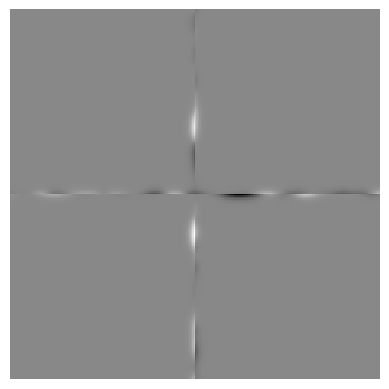

sum difference 0.3836489788163834
-----------------------------------


In [8]:
for overlap_width in range(0, 10, 2):
    print("Overlap width", overlap_width)
    tile_map = da.map_overlap(procedure, tiles, depth=overlap_width, boundary='nearest')
    result = tile_map.compute()
    difference = result - untiled_result
    imshow(difference)
    print("sum difference", difference.sum())
    print("-----------------------------------")

As you can see, the sum difference becomes smaller the wider the overlap is. This is obviously related to the `procedure` we applied. Depending on the filters applied to the image, we need a different overlap width to eliminate the error.

## Exercise
Determine the overlap width you need to get artifact-free images.